# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
# from thick_ptycho.sample_space.sample_space import SampleSpace
# from thick_ptycho.forward_model.solver import ForwardModel
from thick_ptycho.simulation.config import SimulationConfig, BoundaryType, ProbeType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import ForwardModelPWEIterative, ForwardModelPWEFull, ForwardModelMS
from matplotlib import pyplot as plt

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

2025-10-31 18:40:52,799 - INFO - === Scan Summary (Continuous) ===
2025-10-31 18:40:52,801 - INFO -   Sample space (x-range): 1.500e-04 m
2025-10-31 18:40:52,803 - INFO -   Sample space (z-range): 7.500e-05 m
2025-10-31 18:40:52,805 - INFO -   Probe diameter:         3.000e-06 m
2025-10-31 18:40:52,806 - INFO -   Number of scan points:  124
2025-10-31 18:40:52,808 - INFO -   Steps in z:             7
2025-10-31 18:40:52,809 - INFO -   Detector Pixels:        778
2025-10-31 18:40:52,812 - INFO -   Max Overlap:            2.421e-06 m
2025-10-31 18:40:52,815 - INFO -   Percentage Overlap:     418000000.00%

2025-10-31 18:40:52,821 - INFO - Saving refractive index field to ./results/ptycho_object_n_true


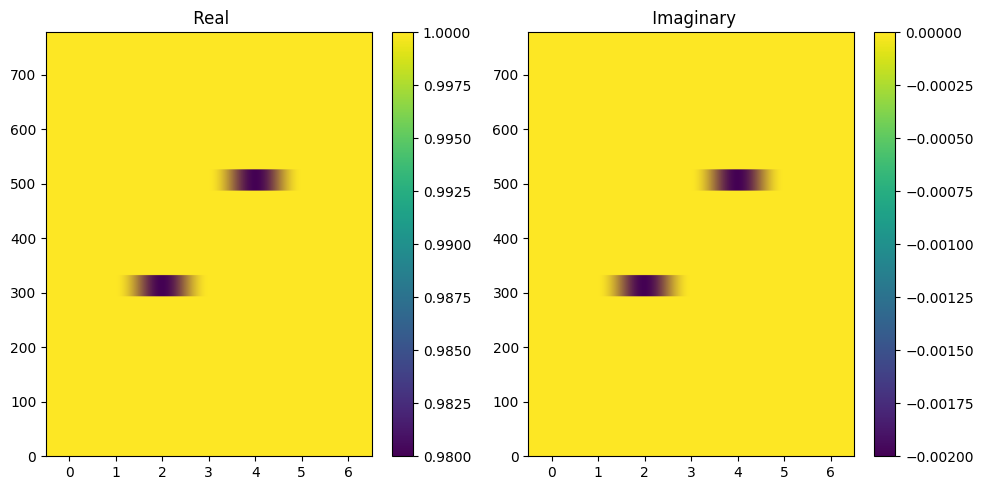

In [2]:
# --- Physical constants ---
from matplotlib.pyplot import imshow


wavelength = 0.635e-6        # meters (0.635 μm)
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]

# --- Refractive index parameters ---
n_medium = 1.0               # background refractive index
delta = 0.01
beta = 0.001
refractive_index_perturbation = -delta - beta * 1j

# --- Probe configuration ---
probe_dimensions_discrete = [20]
probe_diameter_scale = 0.02
probe_focus = -5e-6                    # focal length [m]
scan_points = 124
step_size = 3                        # pixels between scans

pad_factor = 2.0  # Portion of extra space to add
# Define margin portion (half of extra space)
pad_margin = (pad_factor - 1) / 2.0

# --- Simulation spatial dimensions (in meters) ---
xlims = [0.0, 150e-6]   # meters (sample width)
zlims = [0.0, 75e-6]   # meters (sample thickness)
continuous_dimensions = (xlims, zlims)

# --- Discretization parameters ---
z_range = zlims[1] - zlims[0]
dz = wavelength * 16 # For multi-slice, keep dz larger to reduce number of slices
nz = int(z_range / dz)

# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
discrete_dimensions = (int(min_nx * pad_factor), nz)


# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE
probe_type = ProbeType.AIRY_DISK

# --- Create the SimulationConfig object ---
config_ms = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_focus=probe_focus,
    tomographic_projection_90_degree=False,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space_ms = create_simulation_space(config_ms)
simulation_space_ms.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object_ms = create_ptycho_object(simulation_space_ms)


# TODO: Make objects move to the centre with padding or define them in min_nx
# Add 6 spheres of varying positions
gaussian_blur = 0.0
common_side_length = 0.05 # Portion of x-length
common_depth = 0.05  # Portion of z-length

# Add 6 spheres of varying positions
ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(0.4, 0.2), depth=common_depth, gaussian_blur=gaussian_blur)
ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(0.65, 0.5), depth=common_depth, gaussian_blur=gaussian_blur)


# ptycho_object.add_object('circle', refractive_index_perturbation, side_length=common_side_length,  
#                         centre=(0.5, 0.2), depth=common_depth, gaussian_blur=gaussian_blur)
ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(0.4, 0.2), depth=common_depth, gaussian_blur=gaussian_blur)
ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(0.65, 0.5), depth=common_depth, gaussian_blur=gaussian_blur)
# ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(0.4, 0.7), depth=common_depth, gaussian_blur=gaussian_blur)
# ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(0.55, 0.45), depth=common_depth, gaussian_blur=gaussian_blur)
# ptycho_object.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(0.6, 0.3), depth=common_depth, gaussian_blur=gaussian_blur)
ptycho_object_ms.build_field()
ptycho_object_ms.save_n_true("ptycho_object_n_true")
simulation_space_ms.viewer.plot_two_panels(ptycho_object_ms.n_true,view="real_imag")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space_ms)


2025-10-31 18:40:53,459 - INFO - === Scan Summary (Continuous) ===
2025-10-31 18:40:53,463 - INFO -   Sample space (x-range): 1.500e-04 m
2025-10-31 18:40:53,464 - INFO -   Sample space (z-range): 7.500e-05 m
2025-10-31 18:40:53,465 - INFO -   Probe diameter:         3.000e-06 m
2025-10-31 18:40:53,469 - INFO -   Number of scan points:  124
2025-10-31 18:40:53,472 - INFO -   Steps in z:             236
2025-10-31 18:40:53,475 - INFO -   Detector Pixels:        778
2025-10-31 18:40:53,477 - INFO -   Max Overlap:            2.421e-06 m
2025-10-31 18:40:53,478 - INFO -   Percentage Overlap:     418000000.00%



Original refractive index shape: (778, 236)
Loaded refractive index shape: (778, 7)
Loaded refractive index new shape: (778, 236)


(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': ' Real'}>,
        <Axes: title={'center': ' Imaginary'}>], dtype=object))

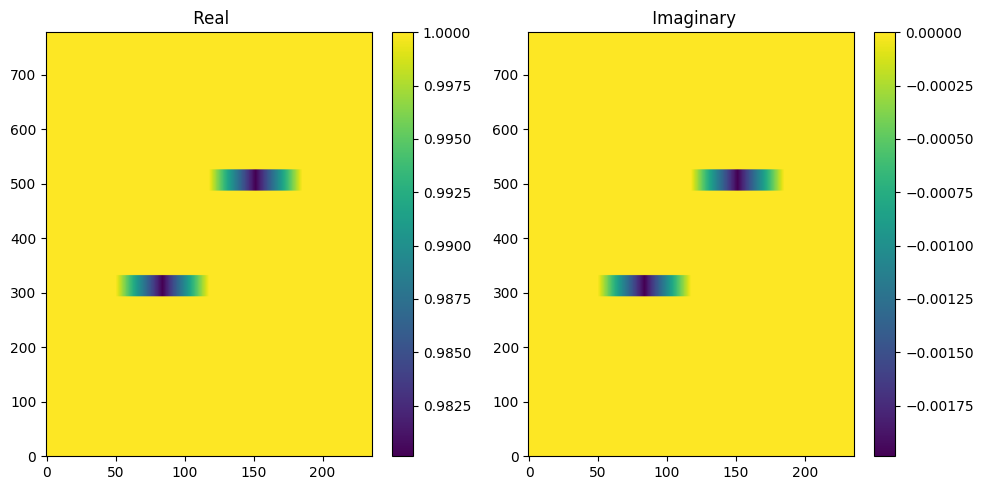

In [3]:
# --- Discretization parameters ---
z_range = zlims[1] - zlims[0]
dz = wavelength / 2
nz = int(z_range / dz)

# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
discrete_dimensions = (int(min_nx * pad_factor), nz)

# --- Create the SimulationConfig object ---
config_pwe = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_focus=probe_focus,
    tomographic_projection_90_degree=False,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space_pwe = create_simulation_space(config_pwe)
simulation_space_pwe.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object_pwe = create_ptycho_object(simulation_space_pwe)
ptycho_object_pwe.load_and_resize_refractive_index("/home/dnz75396/thick_ptycho/notebooks/results/ptycho_object_n_true.npy")
simulation_space_pwe.viewer.plot_two_panels(ptycho_object_pwe.n_true,view="real_imag")


### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [4]:
# Solve Full Space Space, Iterative

# --- Create Forward Model ---
forward_model_pwe = ForwardModelPWEIterative(simulation_space_pwe,
                                ptycho_object_pwe,
                                ptycho_probes)

# Iterative solution
u_pwe = forward_model_pwe.solve()
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=True)
u_pwe = u_pwe[0,0,...]

/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


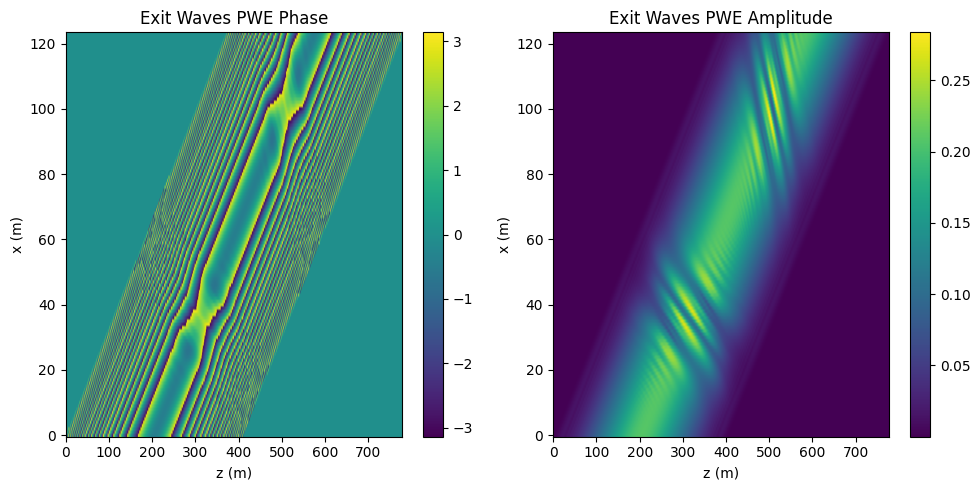

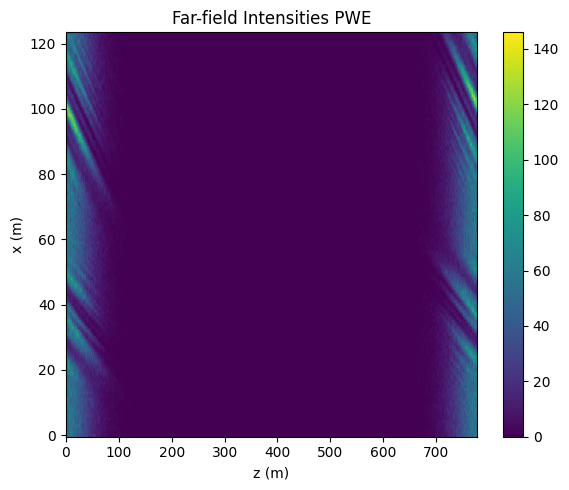

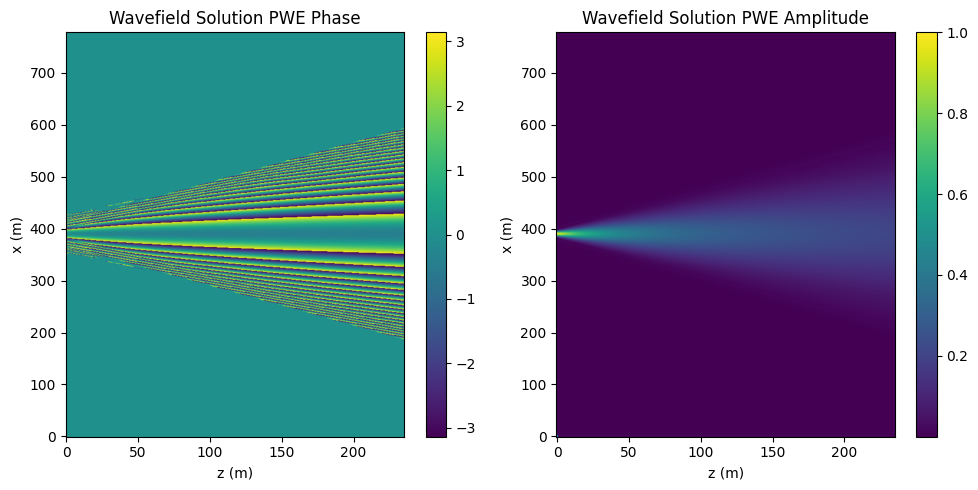

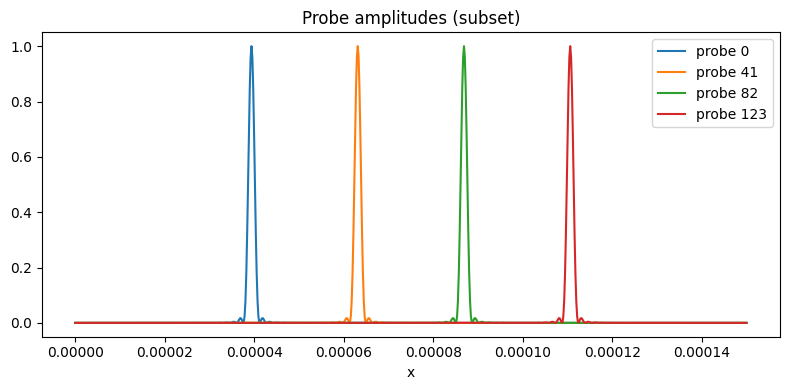

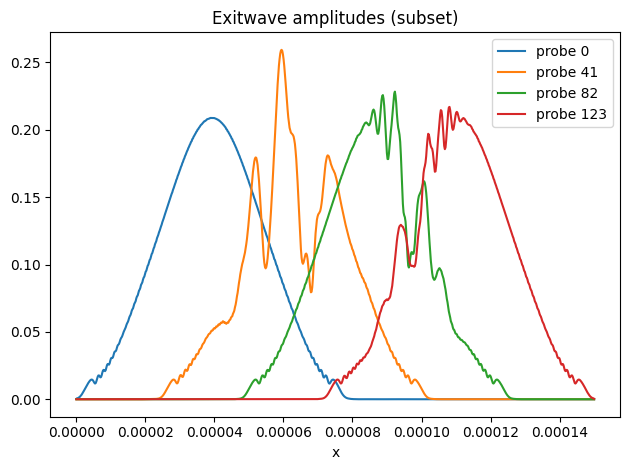

In [5]:
simulation_space_pwe.viewer.plot_two_panels(exit_waves_pwe,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space_pwe.viewer.plot_single_panel(intensities_pwe,
                                        title="Far-field Intensities PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

# Select Centre Probe
centre_probe_pwe = u_pwe[simulation_space_pwe.num_probes//2, ...]
simulation_space_pwe.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

plt.plot(simulation_space_pwe.x, centre_probe_pwe[:, nz//2])
plt.show()

plt.figure(figsize=(8,4))
probe_indices = np.linspace(0, simulation_space_pwe.num_probes-1, min(4, simulation_space_pwe.num_probes), dtype=int)
for p in probe_indices:
    plt.plot(simulation_space_pwe.x, np.abs(u_pwe[p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(simulation_space_pwe.x, np.abs(u_pwe[p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()


In [6]:
# Solve Full Space Space, Multislice

forward_model_ms = ForwardModelMS(simulation_space_ms,
                                ptycho_object_ms,
                                ptycho_probes)

# Iterative solution
u_ms = forward_model_ms.solve()[0,0,...]

exit_waves_ms =forward_model_ms.get_exit_waves(u_ms)
intensities_ms = forward_model_ms.get_farfield_intensities(exit_waves=exit_waves_ms, 
                                                               poisson_noise=True)

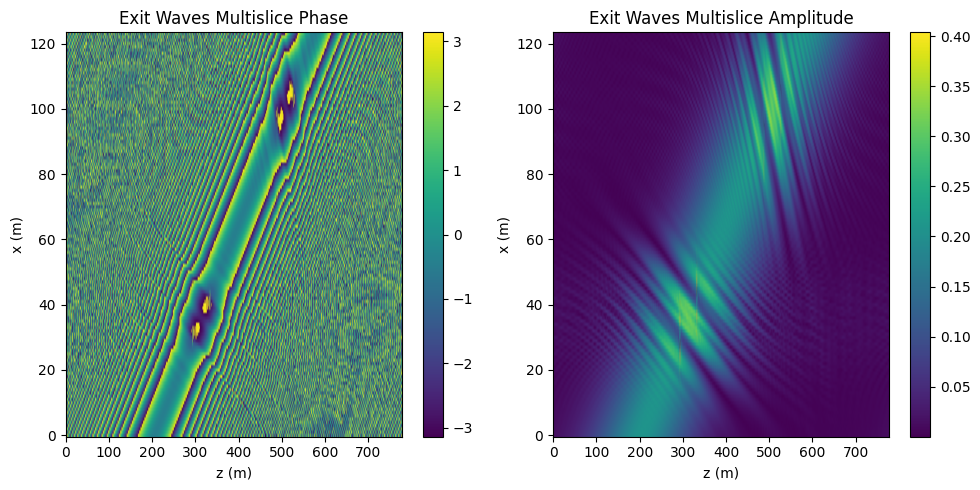

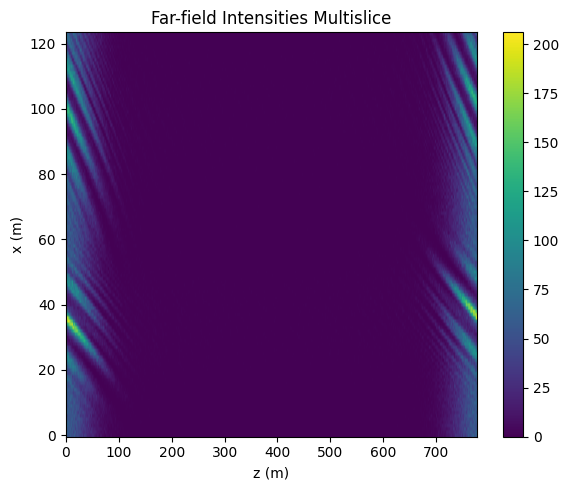

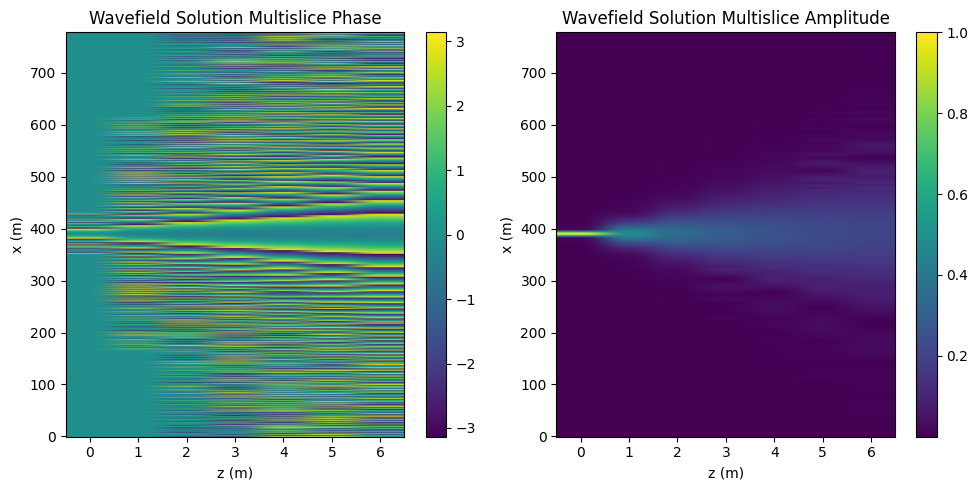

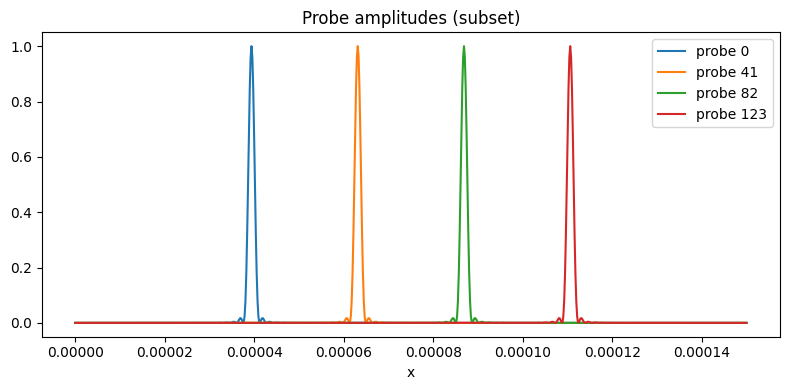

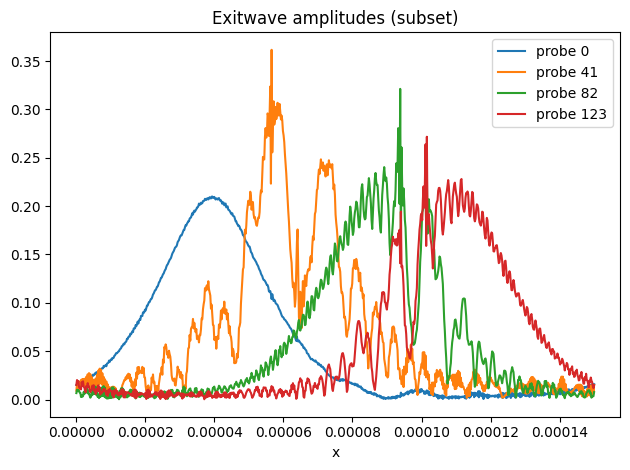

In [7]:
simulation_space_ms.viewer.plot_two_panels(exit_waves_ms,
                                        view="phase_amp", 
                                        title="Exit Waves Multislice",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space_ms.viewer.plot_single_panel(intensities_ms,
                                        title="Far-field Intensities Multislice",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

# Select Centre Probe
centre_probe_ms = u_ms[simulation_space_ms.num_probes//2, ...]
simulation_space_ms.viewer.plot_two_panels(centre_probe_ms,
                                        view="phase_amp", 
                                        title="Wavefield Solution Multislice",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

plt.figure(figsize=(8,4))
probe_indices = np.linspace(0, simulation_space_pwe.num_probes-1, min(4, simulation_space_pwe.num_probes), dtype=int)
for p in probe_indices:
    plt.plot(simulation_space_ms.x, np.abs(u_ms[p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(simulation_space_ms.x, np.abs(u_ms[p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

### 6. Inverse Problem Assuming Phase
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [8]:
complex_data = exit_waves_pwe

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 121.79243152675062
[Iter 002] Mean Loss = 120.64697495993991
[Iter 003] Mean Loss = 120.01787404521632


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

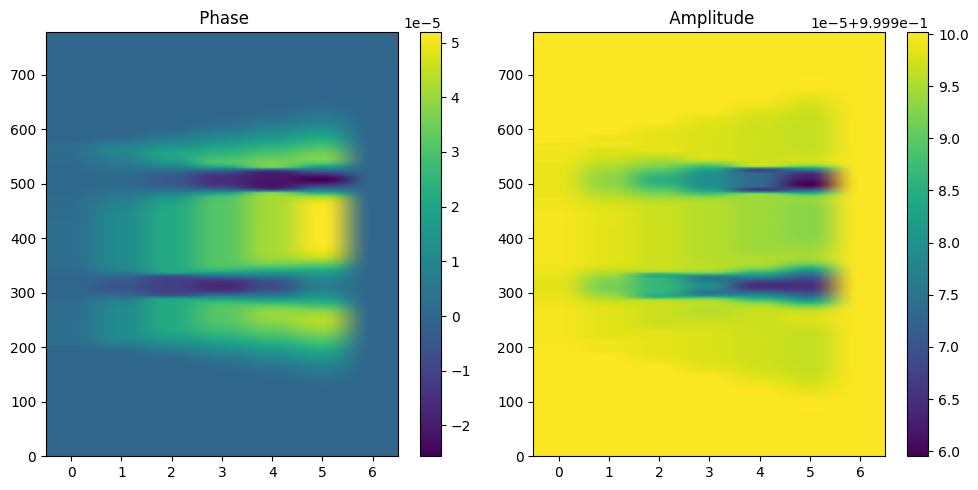

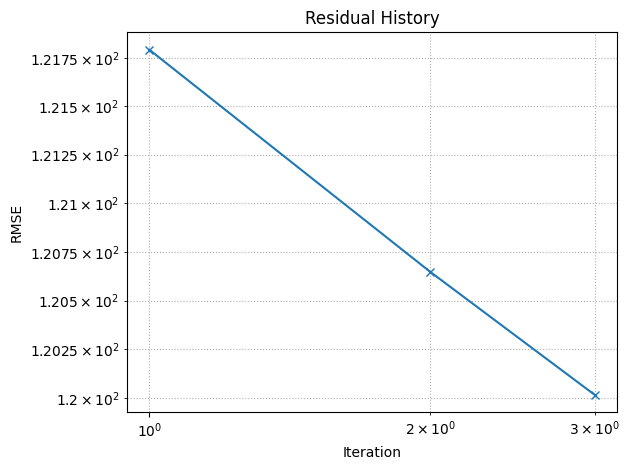

In [9]:
from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
recon_ms = ReconstructorMS(simulation_space_ms, complex_data.squeeze(), phase_retrieval=False, verbose=True)
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=3,alpha_obj=1e-4)
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/3
    RMSE: 0.06277760619077784
    Iteration 1 took 8.60 seconds.
Iteration 2/3
    RMSE: 0.05641615944463402
    Iteration 2 took 8.64 seconds.
Iteration 3/3
    RMSE: 0.05151030201494321
    Iteration 3 took 9.25 seconds.


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

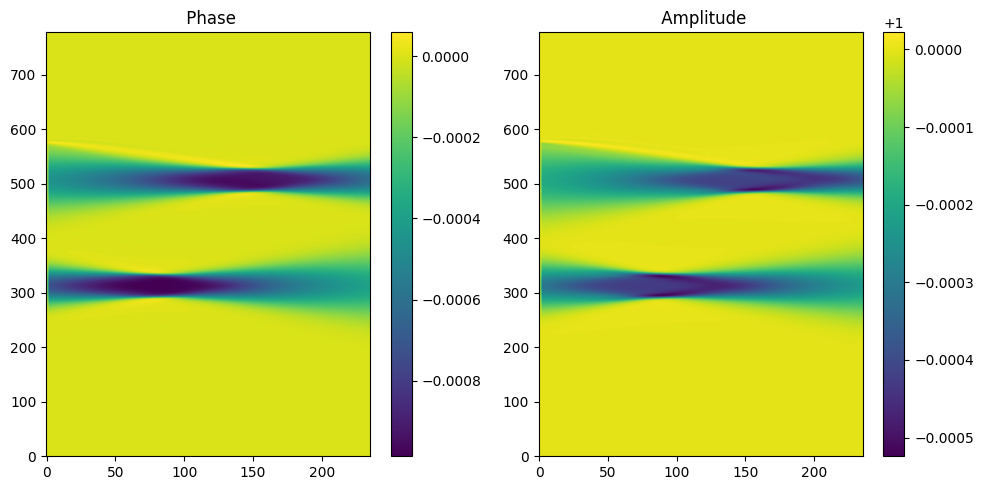

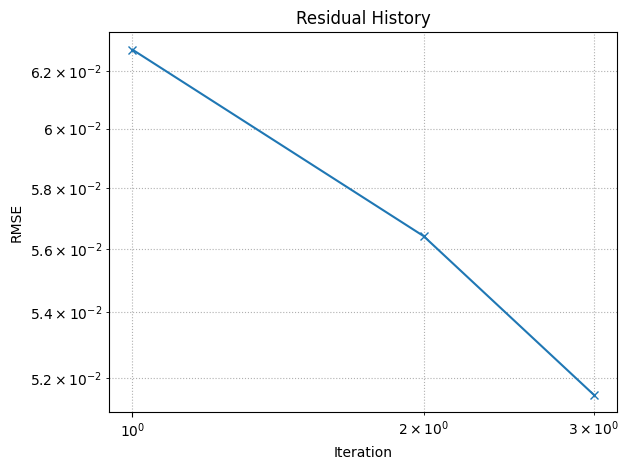

In [10]:
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

recon_pwe = ReconstructorPWE(simulation_space_pwe, complex_data, phase_retrieval=False, verbose=True)
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=3)
simulation_space_pwe.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space_pwe.viewer.plot_residual(residual_pwe)

In [11]:
print(f"Inf MS Error: {np.max(np.abs(n_est_ms - ptycho_object_ms.n_true))}")
print(f"Inf PWE Error: {np.max(np.abs(n_est_pwe - ptycho_object_pwe.n_true))}")

Inf MS Error: 0.02008518069473136
Inf PWE Error: 0.019496894243997018


## Phase Retrieval

In [12]:
data = intensities_pwe

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.07833690402061252
[Iter 002] Mean Loss = 0.07793686861714887
[Iter 003] Mean Loss = 0.0777181061041851


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

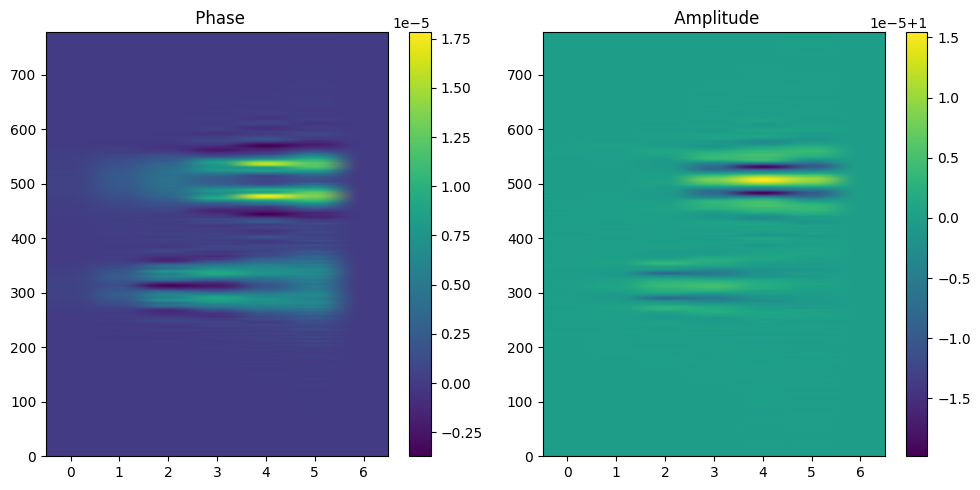

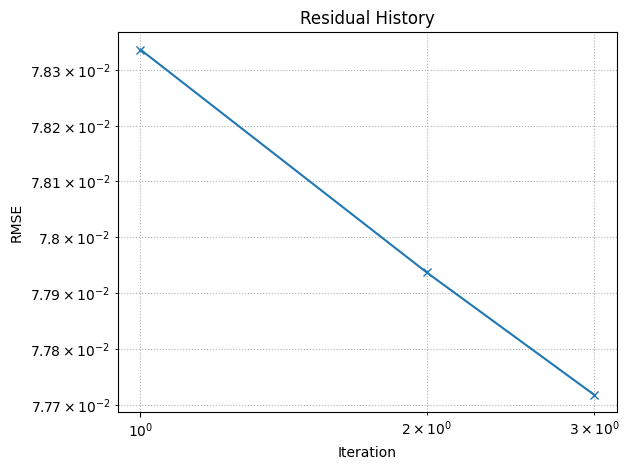

In [13]:

recon_ms = ReconstructorMS(simulation_space_ms, data.squeeze(), phase_retrieval=True, verbose=True)
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=3,alpha_obj=1e-4)
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/3
    RMSE: 0.023040953929296507
    Iteration 1 took 10.43 seconds.
Iteration 2/3
    RMSE: 0.020111486365633327
    Iteration 2 took 9.40 seconds.
Iteration 3/3
    RMSE: 0.01819861892474486
    Iteration 3 took 9.22 seconds.


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

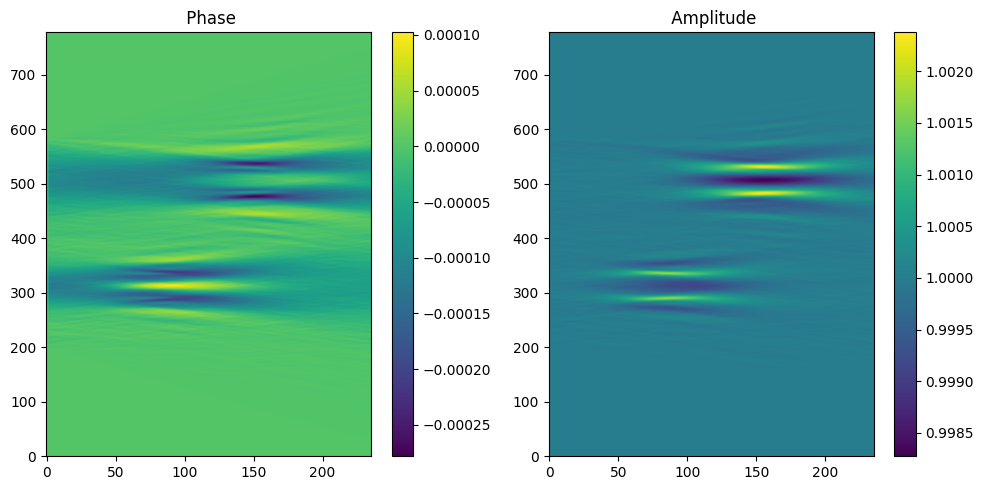

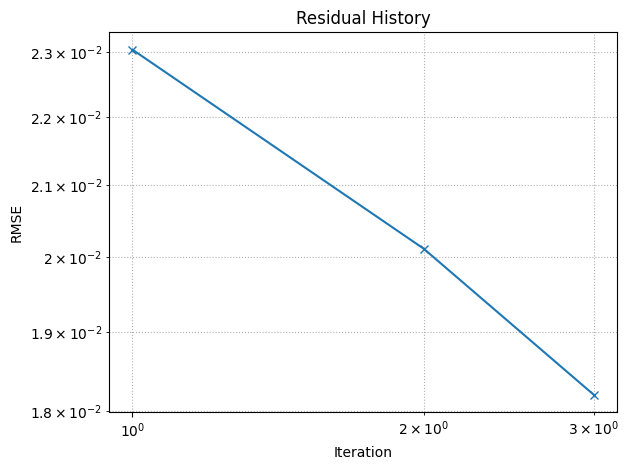

In [14]:
recon_pwe = ReconstructorPWE(simulation_space_pwe, data, phase_retrieval=True, verbose=True)
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=3)
simulation_space_pwe.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space_pwe.viewer.plot_residual(residual_pwe)

In [15]:
print(f"Inf MS Error: {np.max(np.abs(n_est_ms - ptycho_object_ms.n_true))}")
print(f"Inf PWE Error: {np.max(np.abs(n_est_pwe - ptycho_object_pwe.n_true))}")

Inf MS Error: 0.020115199382092875
Inf PWE Error: 0.020969123578856667
